In [ ]:
from data_utils import get_tvsd_dataset, load_data
from moment_utils import getest_all

DATAROOT = './'

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [21]:
data = load_data(DATAROOT)

sub_names = ['F', 'N']
roi_names = ['V1', 'V4', 'IT']

roi_data = {}
for sub_name in sub_names:

    roi_data[sub_name] = {}
    for roi_name in roi_names:
        roi = np.asarray(data[sub_name]['df'][roi_name].tolist())
        roi_data[sub_name][roi_name] = roi

In [ ]:
# Do both within-animal and across-animal comparisons

P = 1000  # Number of samples to draw
num_repeat = 250  # Number of times to repeat the sampling

Qres = 6  # Number of Q's to sample uniformly

# Within-animal and within-region CKA computation
within_Q_lists = {}
within_ckas = {}
for sub_name in sub_names:

    for roi_name in roi_names:

        Phi = roi_data[sub_name][roi_name]
        Pa, Qa = Phi.shape
        Q_list = np.logspace(np.log10(16), np.log10(Qa/2), Qres).astype(int)

        ckas = []
        for Q in Q_list:

            print('\r {}, {}, {}'.format(sub_name, roi_name, Q), end='')

            trials = []
            for i in range(num_repeat):

                idx_P = np.random.choice(np.arange(Pa), P, replace=False)
                idx_Q = np.random.choice(np.arange(Qa), 2*Q, replace=False)
                idx_Qa = idx_Q[:Q]
                idx_Qb = idx_Q[Q:]

                Phi_a = Phi[:, idx_Qa][idx_P, :]
                Phi_b = Phi[:, idx_Qb][idx_P, :]

                # Calculate estimated numerator using Naive, Song and ours
                num = list(getest_all(Phi_a, Phi_b, indep_cols=True))

                # Calculate estimated denominators using Naive, Song and ours
                denom1 = list(getest_all(Phi_a, Phi_a, indep_cols=False))
                denom2 = list(getest_all(Phi_b, Phi_b, indep_cols=False))

                trials.append([num, denom1, denom2])
            ckas.append(trials)

        within_Q_lists[(sub_name, roi_name)] = Q_list
        within_ckas[(sub_name, roi_name)] = np.array(ckas)

 N, IT, 847

In [ ]:
# Across-animal and within-region CKA computation
across_Q_lists = {}
across_ckas = {}
for roi_name in roi_names:

    Phi = roi_data['F'][roi_name]
    Pa, Qa = Phi.shape

    Psi = roi_data['N'][roi_name]
    Pb, Qb = Psi.shape

    assert Pa == Pb

    Q_list = np.logspace(np.log10(16), np.log10(min(Qa, Qb)), Qres).astype(int)

    ckas = []
    for Q in Q_list:

        print('\r {}, {}'.format(roi_name, Q), end='')

        trials = []
        for i in range(num_repeat):

            idx_P = np.random.choice(np.arange(Pa), P, replace=False)
            idx_Qa = np.random.choice(np.arange(Qa), Q, replace=False)
            idx_Qb = np.random.choice(np.arange(Qb), Q, replace=False)

            Phi_a = Phi[:, idx_Qa][idx_P, :]
            Phi_b = Psi[:, idx_Qb][idx_P, :]

            # Calculate estimated numerator using Naive, Song and ours
            num = list(getest_all(Phi_a, Phi_b, indep_cols=True))

            # Calculate estimated denominators using Naive, Song and ours
            denom1 = list(getest_all(Phi_a, Phi_a, indep_cols=False))
            denom2 = list(getest_all(Phi_b, Phi_b, indep_cols=False))

            trials.append([num, denom1, denom2])
        ckas.append(trials)

    across_Q_lists[roi_name] = Q_list
    across_ckas[roi_name] = np.array(ckas)

 IT, 256

In [17]:
baseline_cka = {}
for key, val in across_ckas.items():
    
    cka_baseline = val[:, :, 0, -1] / np.sqrt(val[:, :, 1, -1] * val[:, :, 2, -1])
    cka_baseline_mean = cka_baseline.mean(-1)
    baseline_cka[key] = cka_baseline_mean[-1]

baseline_cka

{'V1': 0.6258297771450111, 'V4': 0.4492320504226044, 'IT': 0.28507653288199836}

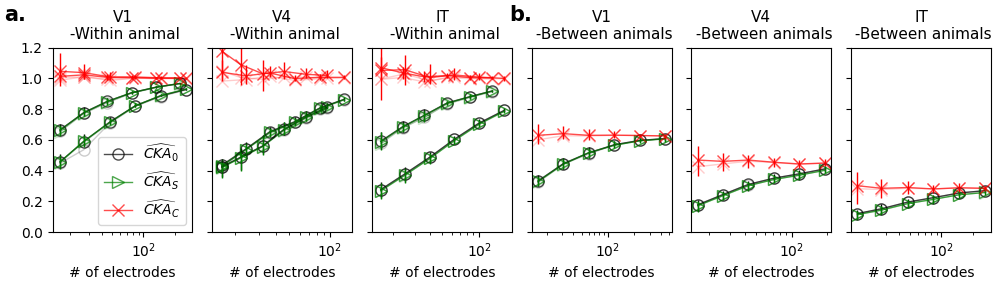

In [18]:
fig, axs = plt.subplots(1, 6, figsize=(10, 3))

alphav = 0.2
alpha = 0.7
ls = '-'
ms = 8
lw = 1

# Plot within-animal and within-region CKA first
for i, roi_name in enumerate(roi_names):

    ax = axs[i]
    ax.set_title(roi_name + '\n -Within animal', fontsize=11)

    Qmin = np.inf
    Qmax = 0
    for k, sub_name in enumerate(sub_names):

        Q_list = within_Q_lists[(sub_name, roi_name)]
        ckas = within_ckas[(sub_name, roi_name)]

        if max(Q_list) > Qmax:
            Qmax = max(Q_list)
        if min(Q_list) < Qmin:
            Qmin = min(Q_list)

        # Plot naive, song and ours in same figure
        for j in range(3):

            if j == 0:
                label = r'$\widehat{CKA}_0$'
                colorv = 'k'
                marker = 'o'
            elif j == 1:
                label = r'$\widehat{CKA}_S$'
                colorv = 'g'
                marker = '>'
            else:
                label = r'$\widehat{CKA}_C$'
                colorv = 'r'
                marker = 'x'

            numer = ckas[:, :, 0, j]
            denum1 = ckas[:, :, 1, j]
            denum2 = ckas[:, :, 2, j]

            cka = numer / np.sqrt(denum1 * denum2)

            yval = np.nanmedian(cka, axis=1)
            lower_error = np.nanquantile(cka, axis=1, q=0.25)
            upper_error = np.nanquantile(cka, axis=1, q=0.75)
            asymmetric_error = [yval-lower_error, upper_error-yval]
            ax.errorbar(Q_list, yval, yerr=asymmetric_error, c=colorv,
                        marker='', ls='', alpha=1, lw=1, zorder=0)
            yval = np.nanmean(cka, axis=1)
            ax.plot(Q_list, yval, c=colorv, marker=marker, ls=ls, alpha=alpha, ms=ms, lw=lw,
                    zorder=0, fillstyle='none', label=label)

            ax.plot(Q_list, numer.mean(-1) / np.sqrt(denum1.mean(-1) * denum2.mean(-1)),
                    alpha=alphav, c=colorv, ls=ls, fillstyle='none', marker=marker, ms=ms, lw=lw)

        if i == 0 and k == 0:
            ax.legend(fontsize=10)

    ax.set_xlim([Qmin*0.85, Qmax*1.15])
    ax.set_ylim([0, 1.2])
    ax.set_xscale('log')

    ax.set_xlabel('# of electrodes')
    if i > 0:
        ax.set_yticklabels([])


for i, roi_name in enumerate(roi_names):

    i += 3
    ax = axs[i]
    ax.set_title(roi_name + '\n -Between animals', fontsize=11)

    Q_list = across_Q_lists[roi_name]
    ckas = across_ckas[roi_name]

    # Plot naive, song and ours in same figure
    for j in range(3):

        if j == 0:
            label = r'$\widehat{CKA}_0$'
            colorv = 'k'
            marker = 'o'
        elif j == 1:
            label = r'$\widehat{CKA}_S$'
            colorv = 'g'
            marker = '>'
        else:
            label = r'$\widehat{CKA}_C$'
            colorv = 'r'
            marker = 'x'

        numer = ckas[:, :, 0, j]
        denum1 = ckas[:, :, 1, j]
        denum2 = ckas[:, :, 2, j]

        cka = numer / np.sqrt(denum1 * denum2)

        yval = np.nanmedian(cka, axis=1)
        lower_error = np.nanquantile(cka, axis=1, q=0.25)
        upper_error = np.nanquantile(cka, axis=1, q=0.75)
        asymmetric_error = [yval-lower_error, upper_error-yval]
        ax.errorbar(Q_list, yval, yerr=asymmetric_error, c=colorv,
                    marker='', ls='', alpha=1, lw=1, zorder=0)
        yval = np.nanmean(cka, axis=1)
        ax.plot(Q_list, yval, c=colorv, marker=marker, ls=ls, alpha=alpha, ms=ms, lw=lw,
                zorder=0, fillstyle='none', label=label)

        ax.plot(Q_list, numer.mean(-1) / np.sqrt(denum1.mean(-1) * denum2.mean(-1)),
                alpha=alphav, c=colorv, ls=ls, fillstyle='none', marker=marker, ms=ms, lw=lw)

    ax.set_ylim([0, 1.2])
    ax.set_xscale('log')

    ax.set_xlabel('# of electrodes')
    if i > 0:
        ax.set_yticklabels([])

    if i == 0 and k == 0:
        ax.legend(fontsize=10)

plt.tight_layout()

bbox = axs[0].get_tightbbox(fig.canvas.get_renderer())
fig.text(bbox.x0, bbox.y1, 'a.', fontsize=15, fontweight="bold", va="top", ha="center",
         transform=None)

bbox = axs[3].get_tightbbox(fig.canvas.get_renderer())
fig.text(bbox.x0, bbox.y1, 'b.', fontsize=15, fontweight="bold", va="top", ha="center",
         transform=None)

plt.show()